In [5]:
import base64
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
import wmfdata
import mwparserfromhell

spark = wmfdata.spark.get_session(
        app_name='interactive',
        extra_settings={
            'spark.jars.packages': 'org.apache.spark:spark-avro_2.11:2.4.4',
            'spark.sql.shuffle.partitions': 512},
        ship_python_env=False)

from pyspark.sql.dataframe import DataFrame
from pyspark.sql import Row, SparkSession, Window
import pyspark.sql.functions as F
import pyspark.sql.types as T


PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


In [6]:
# wav sound files smaller than 10mb from commons
# columns are wmf.mediawiki_wikitext_current and
# wav file bytes
wav = spark.read.format("avro").load('/user/fab/commons_sounds/wav_file/*').cache()
wav.printSchema()


root
 |-- page_id: long (nullable = true)
 |-- page_namespace: integer (nullable = true)
 |-- page_title: string (nullable = true)
 |-- page_redirect_title: string (nullable = true)
 |-- page_restrictions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- user_id: long (nullable = true)
 |-- user_text: string (nullable = true)
 |-- revision_id: long (nullable = true)
 |-- revision_parent_id: long (nullable = true)
 |-- revision_timestamp: string (nullable = true)
 |-- revision_minor_edit: boolean (nullable = true)
 |-- revision_comment: string (nullable = true)
 |-- revision_text_bytes: long (nullable = true)
 |-- revision_text_sha1: string (nullable = true)
 |-- revision_text: string (nullable = true)
 |-- revision_content_model: string (nullable = true)
 |-- revision_content_format: string (nullable = true)
 |-- snapshot: string (nullable = true)
 |-- wiki_db: string (nullable = true)
 |-- file_name: string (nullable = true)
 |-- project: string (nullable =

In [7]:
def extract_description(wikicode):
    names = ['title', 'Title', 'description', 'Description']
    for template in wikicode.filter_templates():
        for name in names:
            if template.has(name, ignore_empty=True):
                return template.get(name).value.strip_code()
    # we give up easily for now, there are likely more ways to extract a description. one can imagine looking for captions, etc
    return None

def extract_categories(wikicode):
    return [ l.title.strip_code() for l in wikicode.filter_wikilinks() if l.title.startswith('Category:')]

@F.udf(returnType="struct<description:string,categories:array<string>>")
def extract_text_features(revision_text):
    features = {}
    try:
        wikicode = mwparserfromhell.parse(revision_text)
    except AttributeError:
        return None
    features['description'] = f"{extract_description(wikicode)}"
    features['categories'] = extract_categories(wikicode)
    return Row(**features)

# append the image feature columns 
dataset = (wav
    .withColumn("text_features", extract_text_features("revision_text"))
    .select('page_title', 'file_bytes_b64', 'text_features.*')
).cache()

In [12]:
top_categories = (dataset
    .select(
        F.explode('categories').alias('category'),
        F.length("file_bytes_b64").alias('file_size')
    ).groupBy('category')
    .agg(
        F.count("*").alias('count'),
        F.sum("file_size").alias('total_size'),
        F.mean("file_size").alias('mean_size')
    )
    .orderBy('count', ascending=False)
    .limit(100).toPandas())
top_categories

category  count  total_size  \
0                      Category:Audio files in Kotava  32522  1483662248   
1                         Category:Odia pronunciation  19074  3292143440   
2   Category:Lingua Libre pronunciation by Sebasti...   7444  1323610612   
3              Category:German pronunciation of nouns   6554  1173199908   
4   Category:Audio files uploaded by User:Psubhashish   3552   597382732   
..                                                ...    ...         ...   
95                     Category:Files by User:Unuaiga     67     8406524   
96                            Category:Edit Johansson     67   431025976   
97                       Category:Tamil pronunciation     66    12057028   
98            Category:Pronunciation of Odia alphabet     64     9857688   
99            Category:Media missing infobox template     64    25969260   

       mean_size  
0   4.562026e+04  
1   1.725985e+05  
2   1.778091e+05  
3   1.790052e+05  
4   1.681821e+05  
..           ...  
95  1.254705e+05  
96  6.433224e+06  
97  1.826822e+05  
98  1.540264e+05  
99  4.057697e+05  

[100 rows x 4 columns]

In [9]:
our_categories = [
    'Category:Folk music of Småland',
    'Category:Audio files of 1951'
]

# empty string means no category match, if multiple apply we join with "_"
encode_categories = F.udf(lambda cs: "_".join(sorted(set(cs)&set(our_categories))), 'string')

(dataset
    .withColumn('our_category', encode_categories('categories'))
    .where(F.col('our_category')!='')    
    .write.format('json').compression('none').mode("overwrite").save('/user/fab/commons_sounds/single_files/example')
    )

#170 files

In [4]:
import base64
import json
import pydoop.hdfs as hdfs
import os
os.environ['HADOOP_CONF_DIR']='/etc/hadoop/conf'

wav_hdfs_dir='/user/fab/commons_sounds/single_files/example/'
http_dir='/srv/published/datasets/one-off/wav/example'

for hdfs_path in hdfs.ls(wav_hdfs_dir):
    with hdfs.open(hdfs_path) as file:
        for line in file:            
            row = json.loads(line)              
            # Category: 
            category = row['our_category'][9:].replace(" ", "_")
            # File:
            file_name = row['page_title'][5:].replace(" ", "_")                        
            !mkdir -p /srv/published/datasets/one-off/wav/example/{category}
            open(f"{http_dir}/{category}/{file_name}",'wb').write(base64.b64decode(row['file_bytes_b64'])) 


In [6]:
wav.select(F.length("file_bytes_b64").alias('file_size')).summary().toPandas()

summary           file_size
0   count              594523
1    mean  195062.95163013038
2  stddev   521379.6885249695
3     min                1780
4     25%              134888
5     50%              156732
6     75%              178576
7     max            13324680

In [11]:
import base64
from io import BytesIO
from scipy.io import wavfile

@F.udf(returnType="struct<sample_rate:int,length:float>")
def read_wav(file_bytes_b64):
    file = BytesIO(base64.b64decode(file_bytes_b64))
    try:
        sample_rate, data =  wavfile.read(file)
        # data=data.ravel()
        return Row(sample_rate=sample_rate, length=(data.shape[0]/sample_rate))
    except Exception as e:
        # TODO
        # haven't investigated, but this does happen
        print("error loading wav")
        
wav = (wav
    .withColumn('wav', read_wav("file_bytes_b64"))
    .drop("file_bytes_b64")
).cache()


In [13]:
print(wav.select("wav.sample_rate").summary().toPandas())
print(wav.select("wav.length").summary().toPandas())

  summary        sample_rate
0   count             592913
1    mean  45171.87233034189
2  stddev  8275.711620104417
3     min                100
4     25%              44100
5     50%              48000
6     75%              48000
7     max             528000
  summary              length
0   count              592913
1    mean  1.4595011438371486
2  stddev  2.9829845891355955
3     min          0.05825397
4     25%           1.1287981
5     50%                1.23
6     75%                1.48
7     max            637.9452


/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data

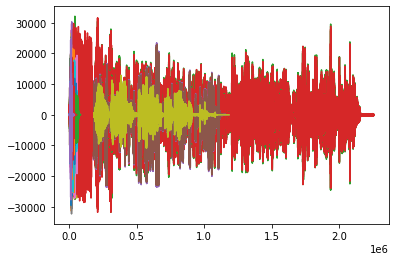

In [17]:
import matplotlib.pyplot as plt
import numpy as np

for r in wav.take(100):
    fb = BytesIO(base64.b64decode(r.file_bytes_b64))    
    try:
        sr, d = wavfile.read(fb)
        plt.plot(d) 
    except:
        pass